In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install evaluate imbalanced-learn matplotlib scikit-learn transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

**Old Model using class weights and 10 epochs**


In [3]:
import os
import numpy as np
import pandas as pd
import evaluate
from transformers import DistilBertForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import precision_recall_fscore_support # Keep for reference, but evaluate handles it
from datasets import Dataset, load_from_disk
import torch
from torch import nn

# Optional: Set environment variable for MPS memory management if needed
# os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Retrieve your Hugging Face access token from your environment (likely not needed for DistilBERT)
hf_token = os.getenv("HF_ACCESS_TOKEN")

# --- Configuration ---
TOKENIZED_DATASET_DIR = '/content/drive/My Drive/Readmissions_Research/Data/tokenized_hf_dataset'
MODEL_CHECKPOINT = "distilbert-base-uncased"
OUTPUT_DIR = "/content/drive/My Drive/Readmissions_Research/Results/ClassWeight_8E"
NUM_LABELS = 2

# --- Class Weights Calculation ---
count_class_0 = 41848
count_class_1 = 8152
total_samples = count_class_0 + count_class_1
weight_class_0 = total_samples / (NUM_LABELS * count_class_0)
weight_class_1 = total_samples / (NUM_LABELS * count_class_1)
class_weights = torch.tensor([weight_class_0, weight_class_1], dtype=torch.float)
print(f"Calculated class weights: {class_weights.tolist()}")

# --- Custom Trainer with Weighted Loss ---
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # Added **kwargs
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- Load Tokenized Dataset from Disk ---
print(f"Loading tokenized dataset from directory: {TOKENIZED_DATASET_DIR}...")
try:
    dataset = load_from_disk(TOKENIZED_DATASET_DIR)
    print(f"Loaded dataset with {len(dataset)} records.")
    print("\nDataset Info:")
    print(dataset)
    required_cols = ['input_ids', 'attention_mask', 'label']
    if not all(col in dataset.column_names for col in required_cols):
        missing_cols = [col for col in required_cols if col not in dataset.column_names]
        raise ValueError(f"Dataset loaded from disk is missing required columns: {missing_cols}")
except FileNotFoundError:
    print(f"Error: Tokenized dataset directory not found at {TOKENIZED_DATASET_DIR}")
    exit()
except Exception as e:
    print(f"Error loading tokenized dataset from disk: {e}")
    exit()

# --- Prepare Dataset for Training ---
print("\nSplitting the dataset...")
split_dataset = dataset.train_test_split(test_size=0.25, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]
print(f"Split data into {len(train_dataset)} training and {len(eval_dataset)} evaluation samples.")

# --- Initialize Model ---
print(f"\nInitializing model from {MODEL_CHECKPOINT}...")
try:
    model = DistilBertForSequenceClassification.from_pretrained(
        MODEL_CHECKPOINT,
        num_labels=NUM_LABELS
    )
    print("Model initialized successfully.")
except Exception as e:
    print(f"Error initializing model: {e}")
    exit()

# --- Define Metrics ---
print("\nLoading evaluation metrics...")
try:
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")
    print("Metrics loaded.")
except Exception as e:
    print(f"Error loading metrics: {e}")

# --- MODIFIED compute_metrics function ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    try:
        accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
        # Removed zero_division=0 from the .compute() calls
        precision = precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"]
        recall = recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"]
        f1 = f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    except Exception as e:
        print(f"Error computing metrics: {e}")
        return {} # Return empty dict if metrics computation fails
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
# --------------------------------------

# --- Training Setup ---
print("\nSetting up training arguments and trainer...")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
except Exception as e:
    print(f"Error initializing tokenizer for DataCollator: {e}")
    exit()

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=100,
    push_to_hub=False,
)

# Use the Custom WeightedTrainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
print("Trainer initialized.")

# --- Train and Evaluate ---
print("\nStarting training...")
try:
    trainer.train()
    print("Training finished.")
except Exception as e:
    print(f"Error during training: {e}")
    exit()

print("\nEvaluating the best model on the evaluation set...")
try:
    eval_results = trainer.evaluate()
    print("\nEvaluation Results:")
    for key, value in eval_results.items():
        print(f"  {key}: {value:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")

print("\nScript finished.")


Calculated class weights: [0.5974001288414001, 3.066732168197632]
Loading tokenized dataset from directory: /content/drive/My Drive/Readmissions_Research/Data/tokenized_hf_dataset...
Loaded dataset with 50000 records.

Dataset Info:
Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 50000
})

Splitting the dataset...
Split data into 37500 training and 12500 evaluation samples.

Initializing model from distilbert-base-uncased...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized successfully.

Loading evaluation metrics...


Metrics loaded.

Setting up training arguments and trainer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<ipython-input-3-19082d32f3c4>:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Trainer initialized.

Starting training...


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: myotherface16 (myotherface16-penn-state) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.820800,0.998221,0.833360,0.468905,0.185440,0.265774
2,0.893600,0.912379,0.841360,0.635870,0.057550,0.105548
3,0.891700,0.823689,0.842960,0.590206,0.112641,0.189178
4,0.875200,0.826112,0.843440,0.585202,0.128382,0.210569
5,0.828800,0.843827,0.838160,0.506702,0.185932,0.272040
6,0.920300,0.923184,0.844240,0.607500,0.119528,0.199753
7,1.051000,0.867842,0.840080,0.523352,0.187408,0.275987
8,0.868500,0.942178,0.838640,0.509412,0.212986,0.300382
9,0.846800,0.951364,0.842080,0.544361,0.178062,0.268347


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.820800,0.998221,0.833360,0.468905,0.185440,0.265774
2,0.893600,0.912379,0.841360,0.635870,0.057550,0.105548
3,0.891700,0.823689,0.842960,0.590206,0.112641,0.189178
4,0.875200,0.826112,0.843440,0.585202,0.128382,0.210569
5,0.828800,0.843827,0.838160,0.506702,0.185932,0.272040
6,0.920300,0.923184,0.844240,0.607500,0.119528,0.199753
7,1.051000,0.867842,0.840080,0.523352,0.187408,0.275987
8,0.868500,0.942178,0.838640,0.509412,0.212986,0.300382
9,0.846800,0.951364,0.842080,0.544361,0.178062,0.268347
10,0.891400,0.967717,0.841680,0.537396,0.190851,0.281670


Training finished.

Evaluating the best model on the evaluation set...



Evaluation Results:
  eval_loss: 0.9422
  eval_accuracy: 0.8386
  eval_precision: 0.5094
  eval_recall: 0.2130
  eval_f1: 0.3004
  eval_runtime: 44.0299
  eval_samples_per_second: 283.8980
  eval_steps_per_second: 70.9740
  epoch: 10.0000

Script finished.


**Code without weight class but with Random Oversampler and 5 Epochs**

In [ ]:
import os
import numpy as np
import pandas as pd
import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset, load_from_disk, Features, Value, Sequence
import torch
from torch import nn
from imblearn.over_sampling import RandomOverSampler # Import RandomOverSampler

# Optional: Set environment variable for MPS memory management if needed
# os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

hf_token = os.getenv("HF_ACCESS_TOKEN")

# --- Configuration ---
TOKENIZED_DATASET_DIR = '/content/drive/My Drive/Readmissions_Research/Data/tokenized_hf_dataset'
MODEL_CHECKPOINT = "distilbert-base-uncased"
OUTPUT_DIR = "/content/drive/My Drive/Readmissions_Research/Results/ClassWeight_5E"
MAX_LENGTH = 512
NUM_LABELS=2
# --- Class Weights Calculation (Still here, but Trainer below uses standard loss) ---
count_class_0 = 28789
count_class_1 = 3588
total_samples = count_class_0 + count_class_1
weight_class_0 = total_samples / (NUM_LABELS * count_class_0)
weight_class_1 = total_samples / (NUM_LABELS * count_class_1)
class_weights = torch.tensor([weight_class_0, weight_class_1], dtype=torch.float)
# print(f"Calculated class weights (can be used with SMOTE or alternatively): {class_weights.tolist()}")

# --- Custom Trainer with Weighted Loss (Not used by default with ROS in this version) ---
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- Load Tokenized Dataset from Disk ---
print(f"Loading tokenized dataset from directory: {TOKENIZED_DATASET_DIR}...")
try:
    dataset = load_from_disk(TOKENIZED_DATASET_DIR)
    print(f"Loaded dataset with {len(dataset)} records.")
    print("\nDataset Info:")
    print(dataset)
    required_cols = ['input_ids', 'attention_mask', 'label']
    if not all(col in dataset.column_names for col in required_cols):
        missing_cols = [col for col in required_cols if col not in dataset.column_names]
        raise ValueError(f"Dataset loaded from disk is missing required columns: {missing_cols}")
except FileNotFoundError:
    print(f"Error: Tokenized dataset directory not found at {TOKENIZED_DATASET_DIR}")
    exit()
except Exception as e:
    print(f"Error loading tokenized dataset from disk: {e}")
    exit()

# --- Prepare Dataset for Training ---
print("\nSplitting the dataset...")
split_dataset = dataset.train_test_split(test_size=0.25, seed=42)
train_dataset_original = split_dataset["train"]
eval_dataset = split_dataset["test"]
print(f"Original training samples: {len(train_dataset_original)}, Evaluation samples: {len(eval_dataset)}")

# --- Apply RandomOverSampler to the Training Data ---
print("\nApplying RandomOverSampler to the training data...")
try:
    # Convert Hugging Face Dataset to pandas DataFrame for imblearn
    train_df_original = train_dataset_original.to_pandas()

    # Separate features (X) from the target (y)
    X_train = train_df_original.drop(columns=['label'])
    y_train = train_df_original['label']

    print(f"Class distribution before RandomOverSampler: {y_train.value_counts().to_dict()}")

    ros = RandomOverSampler(random_state=42)
    # fit_resample will return X_resampled as a pandas DataFrame (if X_train was a DataFrame)
    # and y_resampled as a pandas Series.
    X_resampled_df, y_resampled_series = ros.fit_resample(X_train, y_train)

    # Combine the resampled features and labels back into a single DataFrame
    train_df_resampled = X_resampled_df.copy() # X_resampled_df contains all original columns except 'label'
    train_df_resampled['label'] = y_resampled_series # Add the resampled labels back

    print(f"Class distribution after RandomOverSampler: {train_df_resampled['label'].value_counts().to_dict()}")
    print(f"New training dataset size after RandomOverSampler: {len(train_df_resampled)}")

    # Convert resampled pandas DataFrame back to Hugging Face Dataset
    # Use the features from the original training dataset to ensure schema consistency
    train_dataset = Dataset.from_pandas(train_df_resampled, features=train_dataset_original.features)
    print("Created new training dataset with RandomOverSampler samples.")
    print("\nResampled Training Dataset Info:")
    print(train_dataset)


except ImportError:
    print("Error: `imbalanced-learn` library not found. Please install it: pip install imbalanced-learn")
    print("Skipping RandomOverSampler. Training with original imbalanced training data.")
    train_dataset = train_dataset_original # Fallback
except Exception as e:
    print(f"Error during RandomOverSampler application: {e}")
    print("Skipping RandomOverSampler. Training with original imbalanced training data.")
    train_dataset = train_dataset_original # Fallback


# --- Initialize Model ---
print(f"\nInitializing model from {MODEL_CHECKPOINT}...")
try:
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CHECKPOINT,
        num_labels=NUM_LABELS
    )
    print("Model initialized successfully.")
except Exception as e:
    print(f"Error initializing model: {e}")
    exit()

# --- Define Metrics ---
print("\nLoading evaluation metrics...")
try:
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")
    print("Metrics loaded.")
except Exception as e:
    print(f"Error loading metrics: {e}")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    try:
        accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
        precision = precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"]
        recall = recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"]
        f1 = f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    except Exception as e:
        print(f"Error computing metrics (inside try block): {e}")
        return {"accuracy": 0.0, "precision": 0.0, "recall": 0.0, "f1": 0.0}
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# --- Training Setup ---
print("\nSetting up training arguments and trainer...")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT) # For DataCollator
except Exception as e:
    print(f"Error initializing tokenizer for DataCollator: {e}")
    exit()

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir='./logs_oversampled',
    logging_steps=100,
    push_to_hub=False,
)

print("Using standard Trainer as RandomOverSampler has (likely) balanced the training data.")
trainer = Trainer( # Using standard Trainer
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
print("Trainer initialized.")

# --- Train and Evaluate ---
print("\nStarting training...")
try:
    trainer.train()
    print("Training finished.")
except Exception as e:
    print(f"Error during training: {e}")
    exit()

print("\nEvaluating the best model on the evaluation set...")
try:
    eval_results = trainer.evaluate()
    print("\nEvaluation Results:")
    for key, value in eval_results.items():
        print(f"  {key}: {value:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")

print("\nScript finished.")


Loading tokenized dataset from directory: /content/drive/My Drive/tokenized_hf_dataset...
Loaded dataset with 32386 records.

Dataset Info:
Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 32386
})

Splitting the dataset...
Original training samples: 24289, Evaluation samples: 8097

Applying RandomOverSampler to the training data...
Class distribution before RandomOverSampler: {0: 21615, 1: 2674}
Class distribution after RandomOverSampler: {0: 21615, 1: 21615}
New training dataset size after RandomOverSampler: 43230
Created new training dataset with RandomOverSampler samples.

Resampled Training Dataset Info:
Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 43230
})

Initializing model from distilbert-base-uncased...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized successfully.

Loading evaluation metrics...
Metrics loaded.

Setting up training arguments and trainer...


<ipython-input-1-68e6ac987219>:172: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer( # Using standard Trainer


Using standard Trainer as RandomOverSampler has (likely) balanced the training data.
Trainer initialized.

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.688900,0.673283,0.663198,0.178063,0.548847,0.268889
2,0.617200,0.776806,0.595070,0.157864,0.597146,0.249713
3,0.640100,0.601118,0.707668,0.172320,0.418222,0.244074
4,0.565800,0.880702,0.681407,0.173674,0.485181,0.255787
5,0.723200,1.010229,0.707172,0.176968,0.436883,0.251899
6,0.528100,1.011770,0.786944,0.187645,0.266740,0.220308
7,0.318600,1.202744,0.782485,0.183521,0.268935,0.218166
8,0.325200,1.372085,0.793757,0.184255,0.241493,0.209026
9,0.250900,1.525609,0.794129,0.185247,0.242591,0.210076
10,0.227700,1.556885,0.805153,0.172277,0.190999,0.181156


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.688900,0.673283,0.663198,0.178063,0.548847,0.268889
2,0.617200,0.776806,0.595070,0.157864,0.597146,0.249713
3,0.640100,0.601118,0.707668,0.172320,0.418222,0.244074
4,0.565800,0.880702,0.681407,0.173674,0.485181,0.255787
5,0.723200,1.010229,0.707172,0.176968,0.436883,0.251899
6,0.528100,1.011770,0.786944,0.187645,0.266740,0.220308
7,0.318600,1.202744,0.782485,0.183521,0.268935,0.218166
8,0.325200,1.372085,0.793757,0.184255,0.241493,0.209026
9,0.250900,1.525609,0.794129,0.185247,0.242591,0.210076
10,0.227700,1.556885,0.805153,0.172277,0.190999,0.181156


Training finished.

Evaluating the best model on the evaluation set...



Evaluation Results:
  eval_loss: 0.6733
  eval_accuracy: 0.6632
  eval_precision: 0.1781
  eval_recall: 0.5488
  eval_f1: 0.2689
  eval_runtime: 164.0553
  eval_samples_per_second: 49.3740
  eval_steps_per_second: 12.3430
  epoch: 15.0000

Script finished.


**RandomOversampler with Threshold tuning and 15 epcohs**


Loading tokenized dataset from directory: /content/drive/My Drive/Readmissions_Research/Data/tokenized_hf_dataset...
Loaded dataset with 50000 records.

Splitting the dataset...
Original training samples: 37500, Evaluation samples: 12500

Applying RandomOverSampler to the training data...
Class distribution before RandomOverSampler: {0: 31381, 1: 6119}
Class distribution after RandomOverSampler: {1: 31381, 0: 31381}
New training dataset size after RandomOverSampler: 62762
Created new training dataset with RandomOverSampler samples.

Initializing model from distilbert-base-uncased...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized successfully.

Loading evaluation metrics...


Metrics loaded.

Setting up training arguments and trainer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Using standard Trainer as RandomOverSampler has (likely) balanced the training data.


<ipython-input-3-433f38936d92>:133: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Trainer initialized.

Starting training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: myotherface16 (myotherface16-penn-state) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.658000,0.779811,0.659760,0.268267,0.632071,0.376667
2,0.607600,0.595564,0.757840,0.323509,0.448106,0.375748
3,0.575800,0.714320,0.679520,0.267718,0.559272,0.362102
4,0.646700,0.773864,0.698000,0.261631,0.470241,0.336205
5,0.521000,1.043733,0.731520,0.282186,0.421545,0.338067
6,0.481300,1.260374,0.738240,0.279302,0.385637,0.323967
7,0.422700,1.418505,0.758720,0.299633,0.361535,0.327686
8,0.379000,1.537684,0.747360,0.277931,0.346286,0.308366
9,0.336800,1.685143,0.756800,0.282317,0.321200,0.300506
10,0.211600,1.719733,0.778400,0.290268,0.250861,0.269129


Training finished.

Evaluating the best model on the evaluation set (default threshold 0.5)...



Evaluation Results (Default Threshold):
  eval_loss: 0.7798
  eval_accuracy: 0.6598
  eval_precision: 0.2683
  eval_recall: 0.6321
  eval_f1: 0.3767
  eval_runtime: 29.5465
  eval_samples_per_second: 423.0620
  eval_steps_per_second: 105.7650
  epoch: 15.0000

--- Starting Threshold Tuning ---
Successfully got probabilities for 12500 evaluation samples.

--- Threshold Tuning Results ---
Best Threshold found: 0.51
  Precision at best threshold: 0.2710
  Recall at best threshold:    0.6208
  F1-Score at best threshold:  0.3773
Threshold tuning plot saved to /content/drive/My Drive/Readmissions_Research/Results/RandomOverSampler_ThresholdTuning_15E/threshold_tuning_plot_epochs3.png

Script finished.


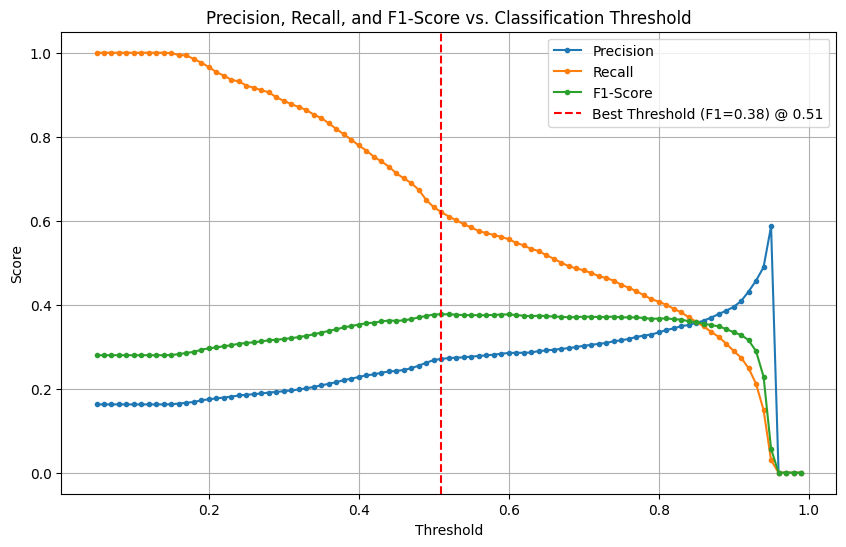

In [ ]:
import os
import numpy as np
import pandas as pd
import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset, load_from_disk, Features, Value, Sequence
import torch
# from torch import nn # No longer needed if WeightedTrainer is removed
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc
import matplotlib.pyplot as plt



hf_token = os.getenv("HF_ACCESS_TOKEN")

# --- Configuration ---
TOKENIZED_DATASET_DIR = '/content/drive/My Drive/Readmissions_Research/Data/tokenized_hf_dataset'
MODEL_CHECKPOINT = "distilbert-base-uncased"
OUTPUT_DIR = "/content/drive/My Drive/Readmissions_Research/Results/RandomOverSampler_ThresholdTuning_15E" # Updated output dir for this experiment
NUM_LABELS = 2
MAX_LENGTH = 512


# --- Load Tokenized Dataset from Disk ---
print(f"Loading tokenized dataset from directory: {TOKENIZED_DATASET_DIR}...")
try:
    dataset = load_from_disk(TOKENIZED_DATASET_DIR)
    print(f"Loaded dataset with {len(dataset)} records.")
    required_cols = ['input_ids', 'attention_mask', 'label']
    if not all(col in dataset.column_names for col in required_cols):
        missing_cols = [col for col in required_cols if col not in dataset.column_names]
        raise ValueError(f"Dataset loaded from disk is missing required columns: {missing_cols}")
except FileNotFoundError:
    print(f"Error: Tokenized dataset directory not found at {TOKENIZED_DATASET_DIR}")
    exit()
except Exception as e:
    print(f"Error loading tokenized dataset from disk: {e}")
    exit()

# --- Prepare Dataset for Training ---
print("\nSplitting the dataset...")
split_dataset = dataset.train_test_split(test_size=0.25, seed=42)
train_dataset_original = split_dataset["train"]
eval_dataset = split_dataset["test"]
print(f"Original training samples: {len(train_dataset_original)}, Evaluation samples: {len(eval_dataset)}")

# --- Apply RandomOverSampler to the Training Data ---
print("\nApplying RandomOverSampler to the training data...")
try:
    train_df_original = train_dataset_original.to_pandas()
    X_train = train_df_original.drop(columns=['label'])
    y_train = train_df_original['label']
    print(f"Class distribution before RandomOverSampler: {y_train.value_counts().to_dict()}")
    ros = RandomOverSampler(random_state=42)
    X_resampled_df, y_resampled_series = ros.fit_resample(X_train, y_train)
    train_df_resampled = X_resampled_df.copy()
    train_df_resampled['label'] = y_resampled_series
    print(f"Class distribution after RandomOverSampler: {train_df_resampled['label'].value_counts().to_dict()}")
    print(f"New training dataset size after RandomOverSampler: {len(train_df_resampled)}")
    train_dataset = Dataset.from_pandas(train_df_resampled, features=train_dataset_original.features)
    print("Created new training dataset with RandomOverSampler samples.")
except ImportError:
    print("Error: `imbalanced-learn` library not found. Please install it: pip install imbalanced-learn")
    train_dataset = train_dataset_original
except Exception as e:
    print(f"Error during RandomOverSampler application: {e}")
    train_dataset = train_dataset_original

# --- Initialize Model ---
print(f"\nInitializing model from {MODEL_CHECKPOINT}...")
try:
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=NUM_LABELS)
    print("Model initialized successfully.")
except Exception as e:
    print(f"Error initializing model: {e}")
    exit()

# --- Define Metrics ---
print("\nLoading evaluation metrics...")
try:
    accuracy_metric_eval = evaluate.load("accuracy")
    precision_metric_eval = evaluate.load("precision")
    recall_metric_eval = evaluate.load("recall")
    f1_metric_eval = evaluate.load("f1")
    print("Metrics loaded.")
except Exception as e:
    print(f"Error loading metrics: {e}")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    try:
        accuracy = accuracy_metric_eval.compute(predictions=predictions, references=labels)["accuracy"]
        precision = precision_metric_eval.compute(predictions=predictions, references=labels, average="binary")["precision"]
        recall = recall_metric_eval.compute(predictions=predictions, references=labels, average="binary")["recall"]
        f1 = f1_metric_eval.compute(predictions=predictions, references=labels, average="binary")["f1"]
    except Exception as e:
        print(f"Error computing metrics (inside try block): {e}")
        return {"accuracy": 0.0, "precision": 0.0, "recall": 0.0, "f1": 0.0}
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# --- Training Setup ---
print("\nSetting up training arguments and trainer...")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
except Exception as e:
    print(f"Error initializing tokenizer for DataCollator: {e}")
    exit()

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    # --- Reduced num_train_epochs to 3 ---
    num_train_epochs=15,
    # -------------------------------------
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir='./logs_oversampled_epochs3', # Updated log dir
    logging_steps=100,
    push_to_hub=False,
)

print("Using standard Trainer as RandomOverSampler has (likely) balanced the training data.")
# --- Using standard Trainer ---
trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
    compute_metrics=compute_metrics, tokenizer=tokenizer, data_collator=data_collator,
)
# -----------------------------
print("Trainer initialized.")

# --- Train and Evaluate ---
print("\nStarting training...")
try:
    trainer.train()
    print("Training finished.")
except Exception as e:
    print(f"Error during training: {e}")
    exit()

print("\nEvaluating the best model on the evaluation set (default threshold 0.5)...")
try:
    eval_results_default_threshold = trainer.evaluate()
    print("\nEvaluation Results (Default Threshold):")
    for key, value in eval_results_default_threshold.items():
        print(f"  {key}: {value:.4f}")
except Exception as e:
    print(f"Error during default threshold evaluation: {e}")

# --- Threshold Tuning Section ---
print("\n--- Starting Threshold Tuning ---")
try:
    predictions_output = trainer.predict(eval_dataset)
    logits = predictions_output.predictions
    true_labels = predictions_output.label_ids
    probabilities_all_classes = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    probs_positive_class = probabilities_all_classes[:, 1]
    print(f"Successfully got probabilities for {len(probs_positive_class)} evaluation samples.")

    thresholds = np.arange(0.05, 1.0, 0.01)
    best_f1 = -1
    best_threshold = -1
    best_precision = -1
    best_recall = -1
    precision_scores, recall_scores, f1_scores_thresh = [], [], []

    for threshold in thresholds:
        predicted_labels = (probs_positive_class >= threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predicted_labels, average='binary', zero_division=0
        )
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores_thresh.append(f1)
        if f1 > best_f1:
            best_f1, best_threshold, best_precision, best_recall = f1, threshold, precision, recall

    print("\n--- Threshold Tuning Results ---")
    print(f"Best Threshold found: {best_threshold:.2f}")
    print(f"  Precision at best threshold: {best_precision:.4f}")
    print(f"  Recall at best threshold:    {best_recall:.4f}")
    print(f"  F1-Score at best threshold:  {best_f1:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_scores, label='Precision', marker='.')
    plt.plot(thresholds, recall_scores, label='Recall', marker='.')
    plt.plot(thresholds, f1_scores_thresh, label='F1-Score', marker='.')
    plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold (F1={best_f1:.2f}) @ {best_threshold:.2f}')
    plt.title('Precision, Recall, and F1-Score vs. Classification Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(OUTPUT_DIR, "threshold_tuning_plot_epochs3.png") # Updated plot name
    plt.savefig(plot_path)
    print(f"Threshold tuning plot saved to {plot_path}")

except Exception as e:
    print(f"Error during threshold tuning: {e}")

print("\nScript finished.")
